# Hyperparameter optimization `no dia` vs (`pre`, `dia`)

## Init config

In [1]:
ordinal_orders = {
    "GenHlth": ["excellent", "very good", "good", "fair", "poor"],
    "Age": [
        "18-24",
        "25-29",
        "30-34",
        "35-39",
        "40-44",
        "45-49",
        "50-54",
        "55-59",
        "60-64",
        "65-69",
        "70-74",
        "75-79",
        "80+",
    ],
    "Education": [
        "no school",
        "elementary",
        "some high school",
        "high school graduate",
        "college",
        "college graduate",
    ],
    "Income": ["<$10k", "<$15k", "<$20k", "<$25k", "<$35k", "<$50k", "<$75k", ">$75k"],
}

In [2]:
import os
from datetime import datetime
import time
import pandas as pd
import numpy as np

import seaborn as sns
from sklearn.metrics import f1_score

from src.config import (
    DATA_SPLIT_DIR,
    TRAIN_RAW_FILENAME,
    VALIDATION_RAW_FILENAME,
    MODELS_DIR,
    STUDY_DIR,
)

os.makedirs(STUDY_DIR, exist_ok=True)

# For Bayesian Optimization
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score, StratifiedKFold

# importing plotly and enable jupyter notebooks for showing optuna visualisations
import plotly.io as pio

pio.renderers.default = "iframe"

# for model comparison
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

from sklearn.exceptions import DataConversionWarning
import warnings

warnings.filterwarnings(action="ignore", category=DataConversionWarning)

d:\Projekte\Predict_Diabetes_From_BRFSS2015\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Bayesian Optimization

### Pipeline

In [3]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# there are only binary values for the nominal columns
nominal_cols = [
    "HighBP",
    "HighChol",
    "CholCheck",
    "Smoker",
    "Stroke",
    "HeartDiseaseorAttack",
    "PhysActivity",
    "Fruits",
    "Veggies",
    "HvyAlcoholConsump",
    "AnyHealthcare",
    "NoDocbcCost",
    "DiffWalk",
    "Sex",
]
nominal_pipe = Pipeline(
    [
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", drop="first")),
    ]
)

ordinal_cols = ["GenHlth", "Age", "Education", "Income"]

ordinal_categories = [ordinal_orders[col] for col in ordinal_cols]

ordinal_pipe = Pipeline(
    [
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("encode", OrdinalEncoder(categories=ordinal_categories)),
    ]
)


numeric_cols = ["BMI", "MentHlth", "PhysHlth"]
num_pipe = Pipeline(
    [("impute", SimpleImputer(strategy="median")), ("scale", StandardScaler())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, numeric_cols),
        ("ord", ordinal_pipe, ordinal_cols),
        ("nom", nominal_pipe, nominal_cols),
    ],
    remainder="drop",
)

pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=5)),
    ]
)

## Load and transform train and validation data

In [4]:
from sklearn.preprocessing import LabelEncoder


df_train_raw = pd.read_csv(os.path.join(DATA_SPLIT_DIR, TRAIN_RAW_FILENAME)).iloc[
    :200, :
]
features_train_raw = df_train_raw.drop("Diabetes_012", axis=1)
target_train_raw = df_train_raw["Diabetes_012"]


df_val_raw = pd.read_csv(os.path.join(DATA_SPLIT_DIR, VALIDATION_RAW_FILENAME))
features_val_raw = df_val_raw.drop("Diabetes_012", axis=1)
target_val_raw = df_val_raw["Diabetes_012"]

# preprocessed_features_train, sampled_target_train
features_train_sampled, target_train_sampled = pipeline.fit_resample(
    features_train_raw, target_train_raw
)


labelencoder = LabelEncoder()

target_train_enc = labelencoder.fit_transform(target_train_raw)
target_train_sampled_enc = labelencoder.transform(target_train_sampled)
target_val_enc = labelencoder.transform(target_val_raw)

### Define Study

In [5]:
model_purpose = "nodia-vs-dia"
study_purpose = f"rf,{model_purpose}"

In [6]:
%%time
# Bayesian Optimization
def objective(trial):
    """return maximized f1-score"""

    # search space

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 30, step=20),
        # "max_features": trial.suggest_categorical(
        #     "max_features", choices=['sqrt', 'log2']
        # ),
        # "max_depth": trial.suggest_int("max_depth", 5, 60, step=5),
        # "min_samples_split": trial.suggest_int(
        #     name="min_samples_split", low=2, high=102, step=5
        # ),
        # "min_samples_leaf": trial.suggest_int(
        #     name="min_samples_leaf", low=1, high=101, step=5
        # ),
    }

    # random forest classifier object
    model_rf = RandomForestClassifier(
        class_weight="balanced",
        random_state=42,
        **params,
    )

    # initiating cv
    scores = cross_val_score(
        estimator=model_rf,
        X=features_train_sampled,
        y=target_train_sampled_enc,
        scoring="f1_macro",
        cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=42),
        n_jobs=-1,
    )

    scores = [score for score in scores if not np.isnan(score)]

    return np.mean(scores)

CPU times: total: 0 ns
Wall time: 0 ns


In [7]:
timestamp = datetime.now()
study_timestamp_str = timestamp.strftime("%Y%m%d%H%M%S")

study_name = f"{study_timestamp_str}_{study_purpose}"



# create a study (aim to maximize score) und setting a seed (random_state) for reproduceability
study = optuna.create_study(
    sampler=TPESampler(seed=42),
    direction="maximize",
    study_name=study_name,
    storage=f"sqlite:///{os.path.join(STUDY_DIR, study_name)}.db",
)

# perform hyperparamter tuning (while timing the process)
time_start = time.time()

[I 2025-07-08 17:35:05,935] A new study created in RDB with name: 20250708173503_rf,nodia-vs-dia


### Run

In [8]:
%%time

study = optuna.load_study(
    study_name=study_name,
    storage=f"sqlite:///{os.path.join(STUDY_DIR, study_name)}.db"
)
study.optimize(objective, n_trials=20)

[I 2025-07-08 17:35:08,118] Trial 0 finished with value: 0.923549790583613 and parameters: {'n_estimators': 10}. Best is trial 0 with value: 0.923549790583613.
[I 2025-07-08 17:35:09,708] Trial 1 finished with value: 0.9356576161921231 and parameters: {'n_estimators': 30}. Best is trial 1 with value: 0.9356576161921231.
[I 2025-07-08 17:35:11,189] Trial 2 finished with value: 0.923549790583613 and parameters: {'n_estimators': 10}. Best is trial 1 with value: 0.9356576161921231.
[I 2025-07-08 17:35:12,964] Trial 3 finished with value: 0.9356576161921231 and parameters: {'n_estimators': 30}. Best is trial 1 with value: 0.9356576161921231.
[I 2025-07-08 17:35:13,241] Trial 4 finished with value: 0.923549790583613 and parameters: {'n_estimators': 10}. Best is trial 1 with value: 0.9356576161921231.
[I 2025-07-08 17:35:13,574] Trial 5 finished with value: 0.923549790583613 and parameters: {'n_estimators': 10}. Best is trial 1 with value: 0.9356576161921231.
[I 2025-07-08 17:35:13,886] Trial

CPU times: total: 844 ms
Wall time: 12.2 s


#### Best parameters

In [9]:
study.best_params

{'n_estimators': 30}

### Retrain

In [10]:
%%time
best_params = study.best_params

classifier = RandomForestClassifier(class_weight="balanced", random_state=42, **best_params)

classifier.fit(features_train_sampled, target_train_sampled_enc)

model_timestamp = datetime.now()

CPU times: total: 109 ms
Wall time: 80.8 ms


In [11]:
type(datetime.now())

datetime.datetime

## Prediction

In [12]:
target_val_pred = classifier.predict(preprocessor.transform(features_val_raw))

## Evaluation

### Metrics

In [13]:
special_features = "smote"

In [14]:
from src.model_evaluation import (
    evaluate_classifier,
    get_classification_report_from_results_as_df,
    get_confusion_matrix_from_results_as_df,
)

target_val_pred_proba = None

if hasattr(classifier, "predict_proba"):
    target_val_pred_proba = classifier.predict_proba(preprocessor.transform(features_val_raw))

    if target_train_raw.nunique() <= 2:
        target_val_pred_proba = target_val_pred_proba[:, 1]


results = evaluate_classifier(
    classifier=classifier,
    labels=list(labelencoder.classes_),
    target_truth=target_val_raw,
    target_pred=labelencoder.inverse_transform(target_val_pred),
    target_pred_proba=target_val_pred_proba,
    timestamp=timestamp,
    model_purpose=model_purpose,
    special_features=special_features,
)

print("precision:", results["precision"])
print("F1:", results["f1"])
print("bal acc:", results["bal_accuracy"])
print("roc auc:", results["roc_auc_score"])

print()
print("confusion_matrix")
display(get_confusion_matrix_from_results_as_df(results))

print()
print("classification_report")
display(get_classification_report_from_results_as_df(results))


labels = results["predicts"]
model_name = results["model_name"]

precision: 0.7947800824986121
F1: 0.8040319153743453
bal acc: 0.39352836394130936
roc auc: 0.6504754847568209

confusion_matrix


,dia,no dia,pre
dia,29,631,126
no dia,622,34957,2205
pre,245,4222,1249



classification_report


,precision,recall,f1-score,support
dia,0.032,0.037,0.034,786
no dia,0.878,0.925,0.901,37784
pre,0.349,0.219,0.269,5716
accuracy,,,0.818,44286
macro avg,0.42,0.394,0.401,44286
weighted avg,0.795,0.818,0.804,44286


### Save the model and results

In [15]:
import pickle
import json
import os

folder = os.path.join(MODELS_DIR, model_name)
filename = os.path.join(folder, model_name)
os.makedirs(folder, exist_ok=True)

with open(f"{filename}.model.pkl", "wb") as f:
    pickle.dump(classifier, f)

with open(f"{filename}.pipeline.pkl", "wb") as f:
    pickle.dump(preprocessor, f)

with open(f"{filename}.label_encoder.pkl", "wb") as f:
    pickle.dump(labelencoder, f)

with open(f"{filename}.model.txt", "w") as file:
    file.write(str(classifier))

with open(f"{filename}.results.json", "w") as f:
    json.dump(results, f, indent=2)

with open(f"{filename}.pipeline_params.txt", "w") as f:
    f.write(preprocessor.get_params().__str__())

with open(f"{filename}.model_params.json", "w") as f:
    json.dump(classifier.get_params(), f, indent=2)

### Learning curves

In [17]:
%%time

scoring_mode = "f1_macro"
train_sizes, train_scores, val_scores = learning_curve(
    estimator=classifier,
    X=features_train_sampled,
    y=target_train_sampled_enc,
    cv=5,
    scoring=scoring_mode,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

df_lc = pd.DataFrame({"train_sizes": train_sizes, "train_scores": train_mean, "val_scores": val_mean})
df_lc.to_csv(f"{filename}.learning_curves.csv", index=False)

CPU times: total: 93.8 ms
Wall time: 849 ms


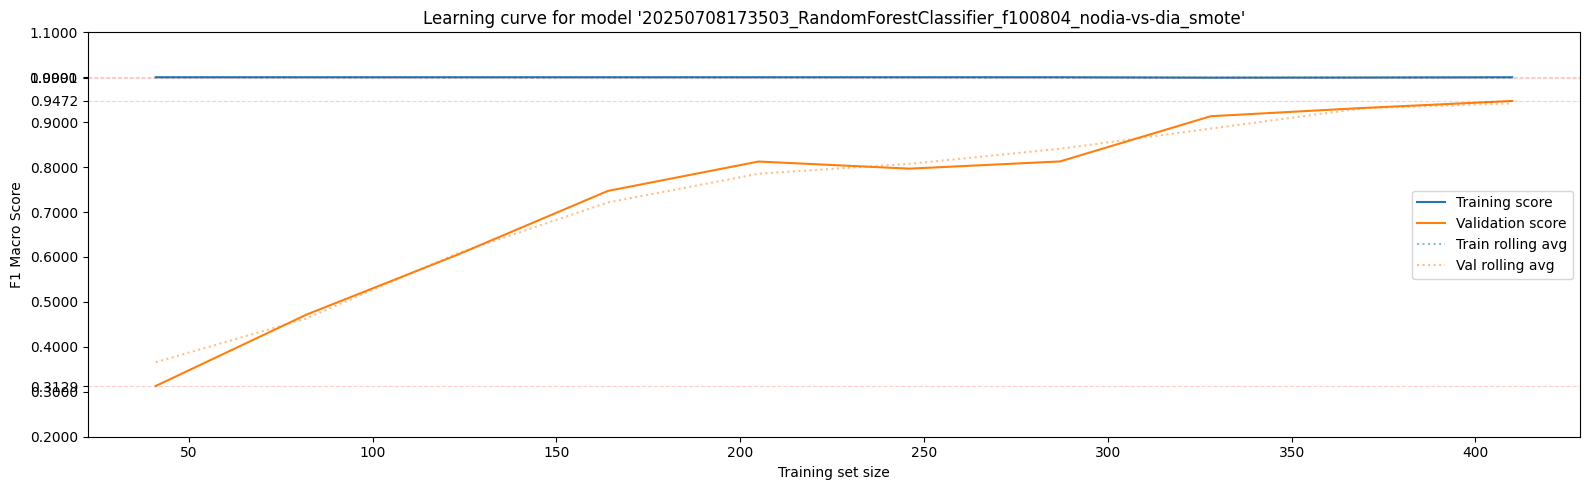

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import io
from scipy.ndimage import uniform_filter1d


fig, ax = plt.subplots(figsize=(16, 5))

# Hauptlinien
train_line, = ax.plot(train_sizes, train_mean, label="Training score")
val_line, = ax.plot(train_sizes, val_mean, label="Validation score")

# Farben extrahieren
train_color = train_line.get_color()
val_color = val_line.get_color()

# Min-/Max-Werte
y_lines_min = [train_mean.min(), val_mean.min()]
y_lines_max = [train_mean.max(), val_mean.max()]

# Hilfslinien
for y in y_lines_min:
    ax.axhline(y, color="red", linestyle="--", linewidth=0.8, alpha=0.2)
for y in y_lines_max:
    ax.axhline(y, color="green", linestyle="--", linewidth=0.8, alpha=0.2)

# Rollender Durchschnitt (Fenstergröße = 3)
train_rolling = uniform_filter1d(train_mean, size=3, mode="nearest")
val_rolling = uniform_filter1d(val_mean, size=3, mode="nearest")

ax.plot(train_sizes, train_rolling, label="Train rolling avg", linestyle=":", linewidth=1.5, color=train_color, alpha=0.5)
ax.plot(train_sizes, val_rolling, label="Val rolling avg", linestyle=":", linewidth=1.5, color=val_color, alpha=0.5)

# y-Ticks
yticks = sorted(set(ax.get_yticks().tolist() + y_lines_min + y_lines_max))
ax.set_yticks(yticks)

ax.set_xlabel("Training set size")
ax.set_ylabel("F1 Macro Score")

ax.set_title(f"Learning curve for model '{model_name}'")

ax.legend()
fig.tight_layout()
fig.savefig(f"{filename}.learning_curve_img.png", format="png")
plt.show()

### Feature importances

In [19]:
import seaborn as sns
from sklearn.metrics import f1_score

target_train_pred = classifier.predict(preprocessor.transform(features_train_raw))

f1_base = f1_score(target_train_enc, target_train_pred, average='weighted')

# The sequence of sampling, transforming and permutating is a tricky one:
# * If transforming is performed before permutating, a column belonging to a one-hot-encoded feature
#   might permutate in a way that a row now contains two 1, but it must not have more than one
#   by definition. So permutation preceeds transformation.
# * Sampling after transforming has the same issue, but most sampling cannot deal with NaN, so it has
#   to preceed transforming.
# * If sampling follows permutation it might result in different rows, because the permutated feature
#   might be relevant for the creation of new rows. This would change the distribution of values for
#   each feature.
# So the chosen sequence is no sampling, permutating, transforming

importances_of_permutations = []
for feat in features_train_raw.columns:
    features_permutated = features_train_raw.copy()

    permutation_run_scores = []
    for i in range(5):
        series_perm = features_permutated[feat].sample(frac=1, replace=False, random_state=0)
        series_perm.reset_index(drop=True, inplace=True)
        features_permutated[feat] = series_perm
        
        preprocessed_features_permutated = preprocessor.transform(features_permutated)
        f1_permutated = f1_score(target_train_enc, classifier.predict(preprocessed_features_permutated), average='weighted')
        permutation_run_scores.append(f1_base - f1_permutated)

    importances_of_permutations.append(np.mean(permutation_run_scores))

feature_importances = pd.Series(data=importances_of_permutations, index=features_train_raw.columns)
feature_importances.sort_values(ascending=False, inplace=True)

with open(f"{filename}.feature_importances.json", "w") as f:
    json.dump(feature_importances.to_dict(), f, indent=2)

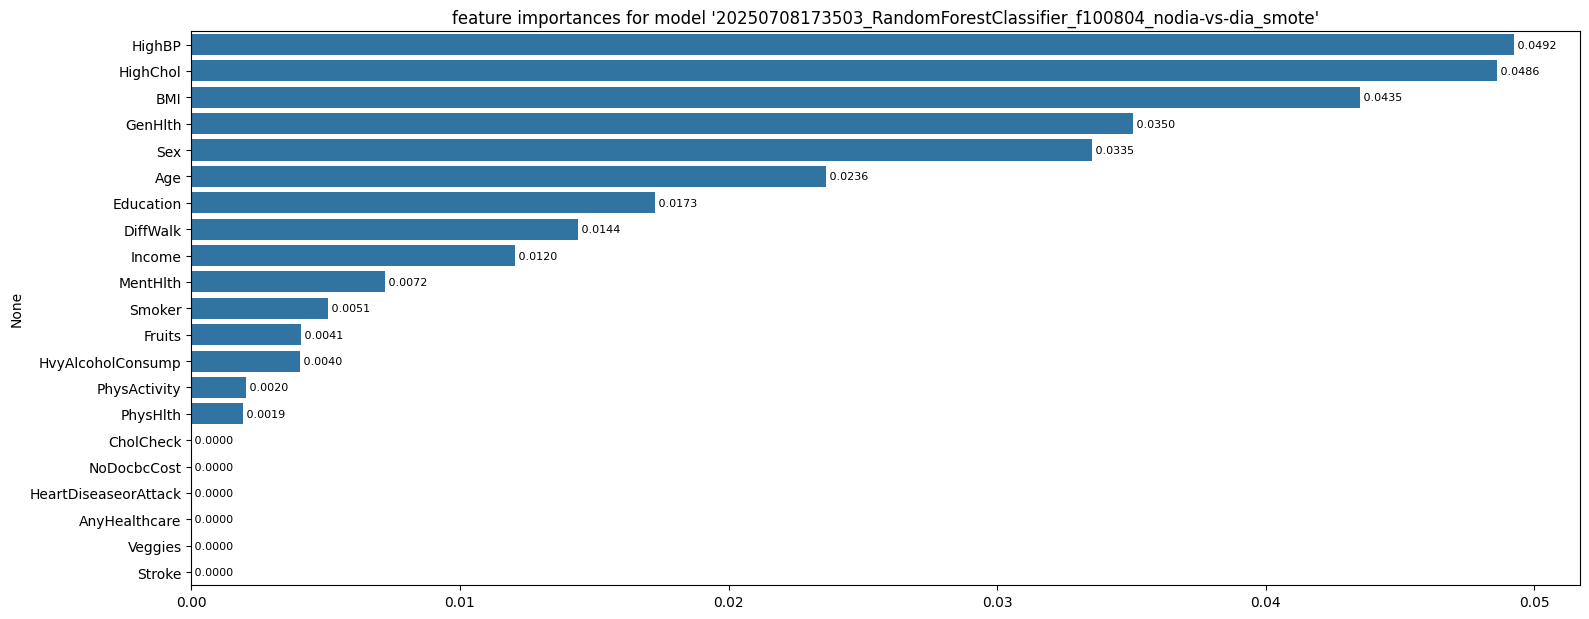

In [20]:
fig, ax = plt.subplots(figsize=(16, 0.3*len(features_val_raw.columns)))
sns.barplot(x=feature_importances.values, y=feature_importances.index,ax=ax)
ax.set_title(f"feature importances for model '{model_name}'")
for i, (val, label) in enumerate(zip(feature_importances.values, feature_importances.index)):
    ax.text(val, i, f" {val:.4f}", va="center", ha="left", fontsize=8)
    
fig.tight_layout()
fig.savefig(f"{filename}.feature_importances.png", format="png")
plt.show()

## Optuna Visualizations

### History

In [21]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

### Parallel coordinates

In [22]:
optuna.visualization.plot_parallel_coordinate(study)

### Parameter importances

In [23]:
optuna.visualization.plot_param_importances(study)